## ADS 509 Final Project
##Cross-Domain Emotion Classification: Evaluating Transfer from Twitter to Reddit Using Traditional and Transformer-Based Models
### Group 3: Allison McKernan, Akshat Patni, Kirsten Emily Drennen

Emotion detection in social media text presents unique challenges due to informal language, platform-specific norms, and domain variability. In this project, we investigate how well emotion classification models trained on Twitter data generalize to Reddit comments, highlighting the impact of cross-domain transfer on performance. Using a traditional TF-IDF + SVM baseline and a fine-tuned transformer model (DistilBERT), we compare in-domain and out-of-domain performance across aligned emotion categories. Our primary research question is: To what extent do supervised emotion classifiers trained on one social media platform generalize to another? By evaluating both classical and transformer-based approaches, we aim to quantify domain shift effects and assess whether pretrained language models meaningfully improve cross-platform robustness.

### Import Libraries & Modules

In [ ]:
!pip install -U transformers datasets accelerate evaluate pyarrow --quiet

In [4]:
import datasets, transformers, pyarrow
print("datasets:", datasets.__version__)
print("transformers:", transformers.__version__)
print("pyarrow:", pyarrow.__version__)

datasets: 4.0.0
transformers: 5.0.0
pyarrow: 18.1.0


In [5]:
import os
import re
import math
import random
import warnings
from dataclasses import dataclass
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")
sns.set_context("talk")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

!pip -q install datasets

from datasets import load_dataset
import pandas as pd

### Load Twitter Data

In [6]:
ds_path = "tweet_emotions.csv"

df = pd.read_csv(ds_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Shape: (40000, 3)
Columns: ['tweet_id', 'sentiment', 'content']


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."


### Exploratory Data Analysis on Twitter Data

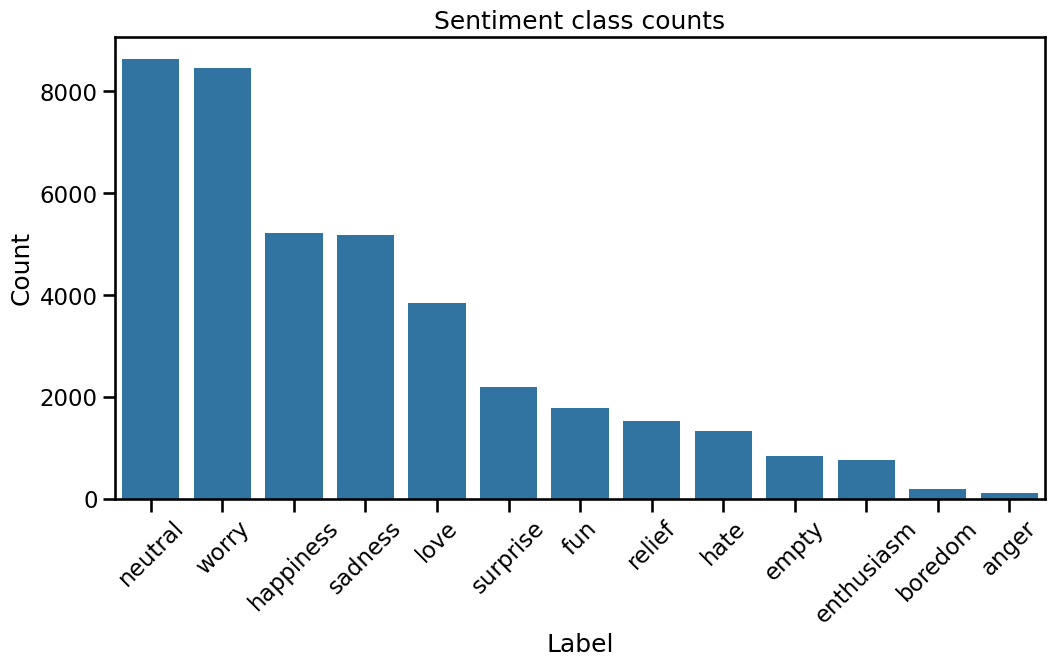

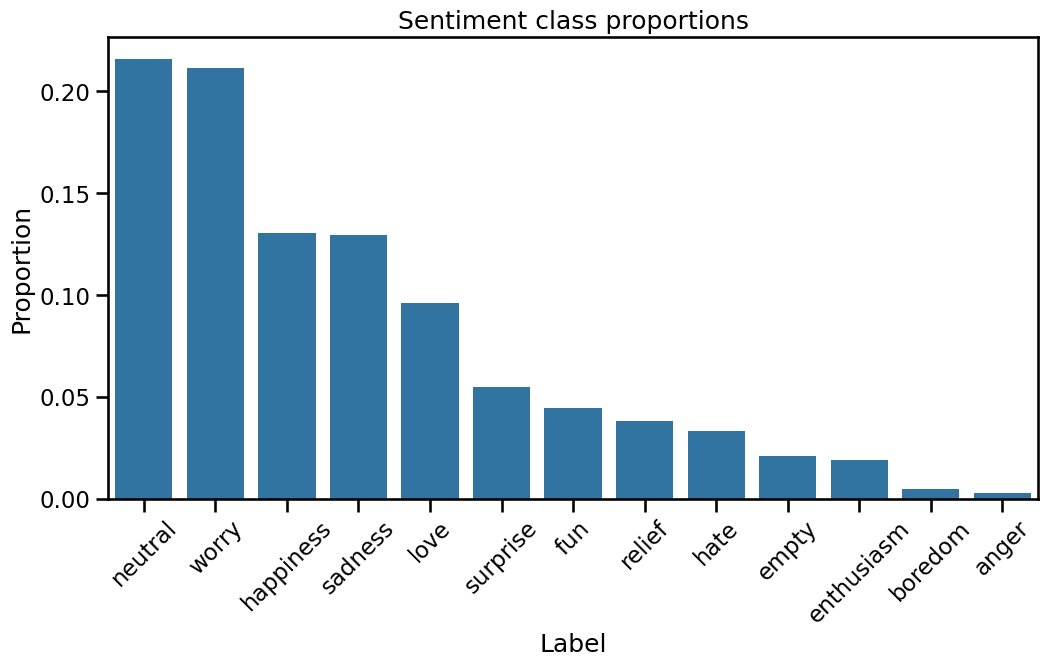

In [7]:
label_counts = df["sentiment"].value_counts()
label_props = label_counts / label_counts.sum()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax)
ax.set_title("Sentiment class counts")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=label_props.index, y=label_props.values, ax=ax)
ax.set_title("Sentiment class proportions")
ax.set_xlabel("Label")
ax.set_ylabel("Proportion")
ax.tick_params(axis="x", rotation=45)
plt.show()

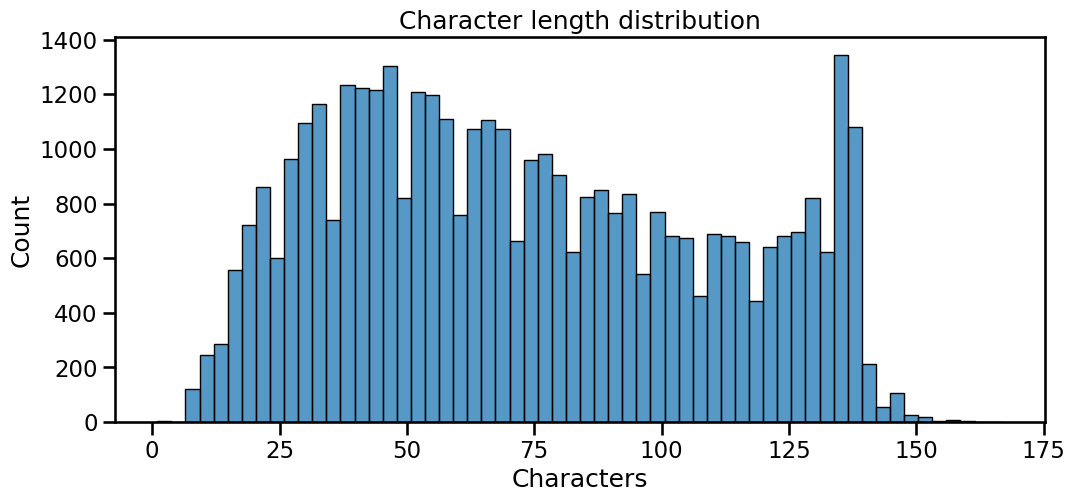

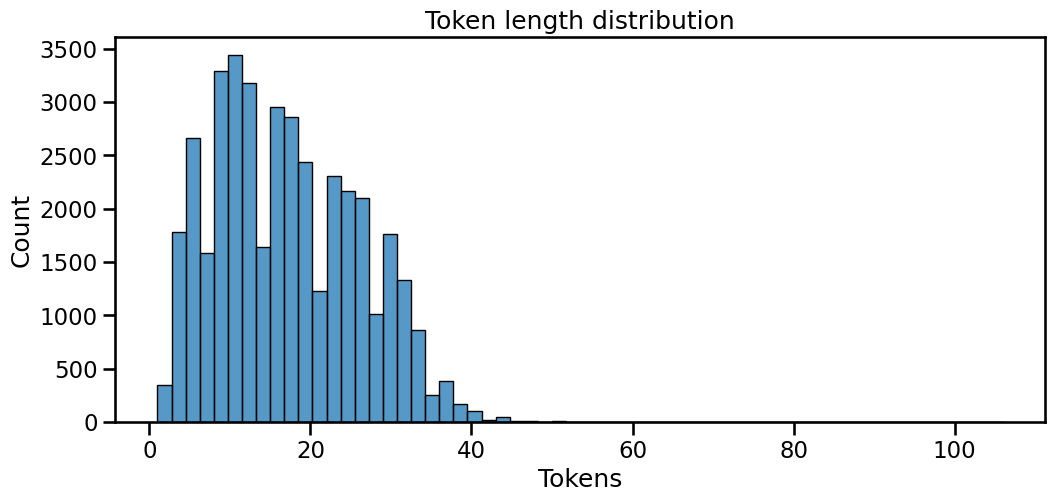

,content,sentiment,char_len,tok_len
32823,Good Morning,neutral,12,2
16298,"I just put my computer up on craigslist. I've had the same case, monitor, and speakers for over 5 years.",empty,104,24
28505,in ten minutes shopping demi lovato-back around demi lovato-behind enemy lines have you all seen the titanic 2 trailer? its really good!,love,138,28
6689,From twitterberry moved to ubertwitter - suffered from BB cache errors,neutral,70,11
26893,@thriftymom TEAR*,sadness,17,4
36572,Ps... I got Ben Button today... completes my Best Picture noms....got all 5 now. It was a GREAT year!!,happiness,102,33
12335,"Just fell asleep for 2 &amp; 1/2 hours so missed both chances for first-look Hollyoaks, ugh",worry,91,23
29591,"@VanetaRogers Thank ye, Vaneta. Much appreciated",happiness,49,9
18948,@donttreeriddle Oh noes!! Melted ice cream = do not want.,sadness,57,14
31067,@orphanth i just had pasta from pizzahut.,relief,42,9


In [8]:
# Text length distributions (chars and tokens)
def simple_tokenize(text: str) -> list:
    return re.findall(r"[A-Za-z0-9_']+|[^\sA-Za-z0-9_]", str(text))

df["char_len"] = df["content"].astype(str).apply(len)
df["tok_len"] = df["content"].astype(str).apply(lambda x: len(simple_tokenize(x)))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df["char_len"], bins=60, ax=ax)
ax.set_title("Character length distribution")
ax.set_xlabel("Characters")
plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df["tok_len"], bins=60, ax=ax)
ax.set_title("Token length distribution")
ax.set_xlabel("Tokens")
plt.show()

display(df[["content", "sentiment", "char_len", "tok_len"]].sample(10, random_state=SEED))


In [9]:
length_by_class = (
    df.groupby("sentiment")[["char_len", "tok_len"]]
    .agg(["count", "mean", "median", "std"])
    .sort_values(("tok_len", "mean"), ascending=False)
)
display(length_by_class)

char_len                              tok_len                            
              count       mean median        std   count       mean median       std
sentiment                                                                           
fun            1776  81.302365   78.5  34.785205    1776  18.822635   18.0  8.469702
hate           1323  78.544974   78.0  36.767167    1323  18.336357   18.0  9.240087
anger           110  77.672727   77.0  35.247255     110  18.054545   17.0  9.086573
surprise       2187  75.741198   71.0  36.317369    2187  17.820302   17.0  8.966196
worry          8459  76.744296   73.0  36.214656    8459  17.742405   17.0  8.686860
sadness        5165  74.991481   71.0  36.257085    5165  17.530494   17.0  8.823342
relief         1526  76.484928   74.0  35.985126    1526  17.473132   17.0  8.681633
happiness      5209  75.604147   71.0  35.612141    5209  17.450566   16.0  8.798756
love           3842  74.497657   70.0  35.748509    3842  17.320927   16.0  8.944407
enthusiasm      759  74.794466   70.0  35.890701     759  17.317523   16.0  8.602055
boredom         179  74.184358   68.0  36.248589     179  17.189944   16.0  8.729886
empty           827  64.604595   59.0  36.395788     827  15.154776   13.0  9.890697
neutral        8638  64.480088   56.0  36.908814    8638  14.886548   13.0  9.181274

In [10]:
# Most frequent words / n-grams by class
def top_ngrams_per_class(data: pd.DataFrame, label_col: str, text_col: str, label: str, ngram_range=(1, 2), top_k=20):
    subset = data[data[label_col] == label][text_col].astype(str).values
    vec = CountVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=ngram_range,
        min_df=5
    )
    X = vec.fit_transform(subset)
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = counts.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": vocab[top_idx], "count": counts[top_idx]})

# Show top unigrams & bigrams for most common classes
top_labels = label_counts.index[:5].tolist()

for lab in top_labels:
    print(f"\n--- Top n-grams for class: {lab} ---")
    display(top_ngrams_per_class(df, "sentiment", "content", lab, ngram_range=(1,1), top_k=15))
    display(top_ngrams_per_class(df, "sentiment", "content", lab, ngram_range=(2,2), top_k=15))


--- Top n-grams for class: neutral ---


,ngram,count
0,just,600
1,http,554
2,day,416
3,com,411
4,quot,386
5,good,359
6,work,337
7,like,337
8,going,314
9,today,284


,ngram,count
0,twitpic com,123
1,http twitpic,117
2,http tinyurl,93
3,tinyurl com,93
4,bit ly,84
5,http bit,84
6,mother day,63
7,good morning,61
8,just got,54
9,mothers day,52



--- Top n-grams for class: worry ---


,ngram,count
0,just,699
1,like,454
2,day,436
3,don,412
4,work,395
5,good,393
6,got,392
7,going,384
8,today,378
9,know,362


,ngram,count
0,don know,91
1,http twitpic,71
2,twitpic com,71
3,just got,63
4,feel like,61
5,sorry hear,49
6,looks like,44
7,don think,40
8,bit ly,37
9,http bit,37



--- Top n-grams for class: happiness ---


,ngram,count
0,day,643
1,good,566
2,just,429
3,happy,417
4,thanks,299
5,great,296
6,lol,293
7,quot,282
8,today,265
9,http,261


,ngram,count
0,mother day,107
1,good morning,107
2,mothers day,87
3,http twitpic,78
4,twitpic com,78
5,happy mother,71
6,happy mothers,64
7,just got,62
8,star wars,53
9,wars day,50



--- Top n-grams for class: sadness ---


,ngram,count
0,just,418
1,sad,385
2,day,349
3,miss,341
4,work,333
5,today,285
6,like,279
7,im,259
8,got,238
9,really,217


,ngram,count
0,feel like,41
1,just got,39
2,twitpic com,38
3,http twitpic,38
4,http bit,27
5,bit ly,27
6,don know,25
7,im sad,24
8,gonna miss,21
9,sorry hear,20



--- Top n-grams for class: love ---


,ngram,count
0,love,865
1,day,784
2,happy,601
3,good,325
4,mothers,303
5,mother,301
6,just,273
7,http,223
8,quot,208
9,thanks,196


,ngram,count
0,mother day,264
1,mothers day,235
2,happy mother,228
3,happy mothers,181
4,twitpic com,77
5,http twitpic,76
6,good morning,40
7,day moms,37
8,day mothers,33
9,day mom,30


### Creating a Baseline model for training

In [11]:
X = df["content"].astype(str)
y = df["sentiment"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

tweet_model = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
    ("clf", LinearSVC())
])

tweet_model.fit(X_train, y_train)

pred_test = tweet_model.predict(X_test)
print(classification_report(y_test, pred_test))
print("Macro F1:", f1_score(y_test, pred_test, average="macro"))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.02      0.01      0.01       165
  enthusiasm       0.06      0.01      0.02       152
         fun       0.11      0.05      0.07       355
   happiness       0.29      0.34      0.32      1042
        hate       0.28      0.17      0.21       265
        love       0.40      0.40      0.40       768
     neutral       0.33      0.39      0.36      1728
      relief       0.14      0.07      0.09       305
     sadness       0.28      0.28      0.28      1033
    surprise       0.12      0.06      0.08       437
       worry       0.33      0.43      0.37      1692

    accuracy                           0.31      8000
   macro avg       0.18      0.17      0.17      8000
weighted avg       0.28      0.31      0.29      8000

Macro F1: 0.17026646557878983


### Pull Reddit Data via Hugging Face API

In [ ]:
# Loading GoEmotions (Reddit) from Hugging Face

from datasets import load_dataset
# Explicitly specify configuration
go = load_dataset("google-research-datasets/go_emotions", "simplified")  # Reddit comments w/ emotion labels
go

#Convert to Dataframe

label_names = go["train"].features["labels"].feature.names

def labels_to_names(label_ids):
    return [label_names[i] for i in label_ids]

df_reddit = pd.DataFrame({
    "id": go["test"]["id"],
    "text": go["test"]["text"],
    "labels": [labels_to_names(x) for x in go["test"]["labels"]],
})

df_reddit.head()

In [13]:
# Mapping Emotion labels to match Twitter Sentiment

twitter_classes = {"anger", "fear", "joy", "love", "sadness", "surprise"}

map_to_6 = {
    "anger": "anger",
    "annoyance": "anger",
    "disapproval": "anger",

    "fear": "fear",
    "nervousness": "fear",

    "joy": "joy",
    "amusement": "joy",
    "excitement": "joy",
    "optimism": "joy",
    "pride": "joy",
    "relief": "joy",

    "love": "love",
    "admiration": "love",
    "gratitude": "love",
    "caring": "love",

    "sadness": "sadness",
    "disappointment": "sadness",
    "grief": "sadness",
    "remorse": "sadness",
    "embarrassment": "sadness",

    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",
    "curiosity": "surprise",
}

# Only use dominant label

def map_comment_to_single_class(label_list):
    mapped = {map_to_6[lbl] for lbl in label_list if lbl in map_to_6}
    if len(mapped) == 1:
        return list(mapped)[0]
    return None

df_reddit["sentiment"] = df_reddit["labels"].apply(map_comment_to_single_class)
df_reddit_eval = df_reddit.dropna(subset=["sentiment"])[["id","text","sentiment"]].copy()

df_reddit_eval["sentiment"].value_counts()

,count
sentiment,
love,985
anger,640
surprise,554
joy,549
sadness,305
fear,87


In [14]:
# Sample the Reddit Dataset

SEED = 42
reddit_eval = df_reddit_eval.sample(1000, random_state=SEED)  # adjust size
reddit_eval.to_csv("reddit_eval_goemotions_mapped.csv", index=False)
reddit_eval.head()

,id,text,sentiment
5048,ee7crld,TeamViolet going strong fam!,love
5170,ef9olan,Thank yous in the form of hand gestures you carrot cake,love
3688,ee1mqwo,Wow. Did not realize [NAME] was a top 20,surprise
395,eddn2u3,But they didn't because it's fake.,anger
1836,efeharq,"I don't remember, it was all very hazy...",sadness


### Expoloratory Data Analysis on Reddit Data

In [15]:
# Overview

reddit_eval.shape
reddit_eval["sentiment"].value_counts()
reddit_eval["text"].str.len().describe()

,text
count,1000.000000
mean,66.967000
std,36.567678
min,6.000000
25%,35.000000
50%,63.000000
75%,96.000000
max,183.000000


<Axes: xlabel='sentiment'>

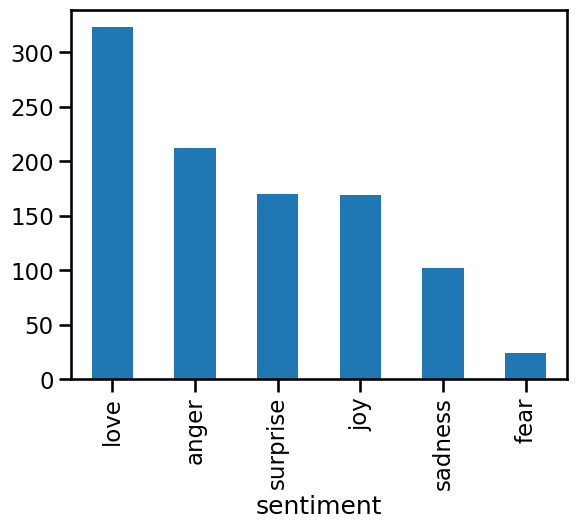

In [16]:
# Label Distribution

reddit_eval["sentiment"].value_counts().plot(kind="bar")

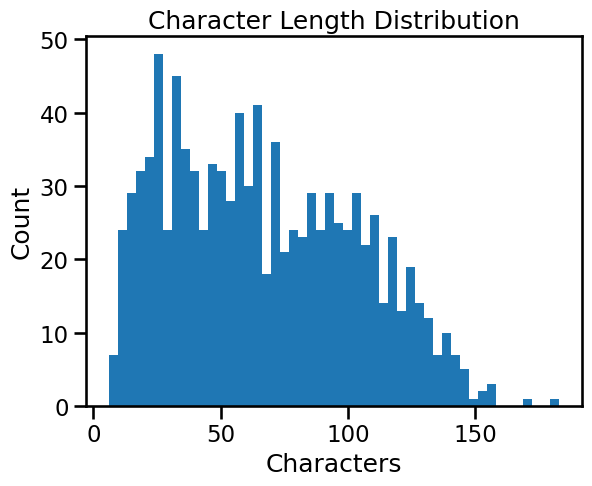

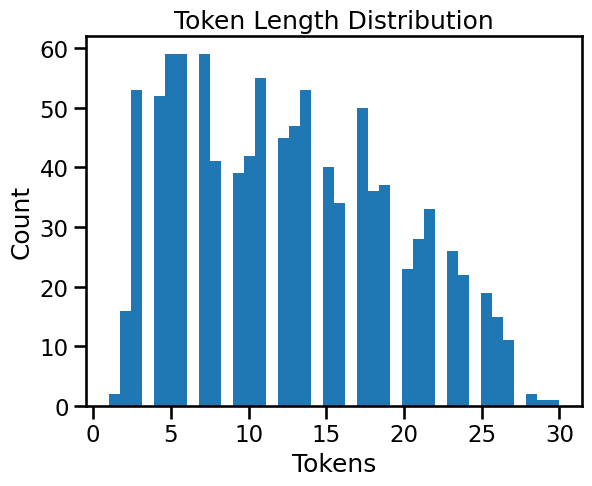

In [17]:
# Length Distribution

# character
reddit_eval["char_length"] = reddit_eval["text"].astype(str).apply(len)

plt.figure()
plt.hist(reddit_eval["char_length"], bins=50)
plt.title("Character Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

# token
reddit_eval["token_length"] = reddit_eval["text"].astype(str).apply(lambda x: len(x.split()))

plt.figure()
plt.hist(reddit_eval["token_length"], bins=40)
plt.title("Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

### Evaluate Twitter-trained model on Reddit



In [18]:
X_reddit = reddit_eval["text"].astype(str)
y_reddit = reddit_eval["sentiment"].astype(str)

pred_reddit = tweet_model.predict(X_reddit)

print(classification_report(y_reddit, pred_reddit))
print("Macro F1 (Reddit OOD):", f1_score(y_reddit, pred_reddit, average="macro"))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       212
     boredom       0.00      0.00      0.00         0
       empty       0.00      0.00      0.00         0
  enthusiasm       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00        24
         fun       0.00      0.00      0.00         0
   happiness       0.00      0.00      0.00         0
        hate       0.00      0.00      0.00         0
         joy       0.00      0.00      0.00       169
        love       0.87      0.26      0.40       323
     neutral       0.00      0.00      0.00         0
      relief       0.00      0.00      0.00         0
     sadness       0.23      0.18      0.20       102
    surprise       0.54      0.13      0.21       170
       worry       0.00      0.00      0.00         0

    accuracy                           0.12      1000
   macro avg       0.11      0.04      0.05      1000
weighted avg       0.40   

The model trained on Twitter emotion data does not generalize well to Reddit comments when evaluated across the full 15-class label space. This performance collapse highlights the importance of label alignment and domain similarity when evaluating cross-platform transfer.

# Align Twitter to 6 Emotion Classes

To ensure fair cross-domain comparison, we align both Twitter and Reddit datasets to the same six emotion classes:

- anger
- fear
- joy
- love
- sadness
- surprise

In [19]:
# Ensure Twitter is aligned to same 6 classes

six_classes = ["anger", "fear", "joy", "love", "sadness", "surprise"]

twitter_map = {
    "anger": "anger",
    "hate": "anger",
    "worry": "fear",
    "fear": "fear",
    "happiness": "joy",
    "fun": "joy",
    "enthusiasm": "joy",
    "relief": "joy",
    "love": "love",
    "sadness": "sadness",
    "surprise": "surprise"
}

df["sentiment_6"] = df["sentiment"].map(twitter_map)
df_6 = df.dropna(subset=["sentiment_6"])

df_6["sentiment_6"].value_counts()

,count
sentiment_6,
joy,9270
fear,8459
sadness,5165
love,3842
surprise,2187
anger,1433


# Train/Test Split (6 Classes)


In [20]:
X = df_6["content"]
y = df_6["sentiment_6"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

baseline_model_6 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=50000)),
    ("clf", LinearSVC())
])

baseline_model_6.fit(X_train, y_train)

pred_twitter_6 = baseline_model_6.predict(X_test)

print("Twitter (6-class) Results")
print(classification_report(y_test, pred_twitter_6))
print("Twitter Macro F1:", f1_score(y_test, pred_twitter_6, average="macro"))

Twitter (6-class) Results
              precision    recall  f1-score   support

       anger       0.34      0.16      0.22       287
        fear       0.41      0.47      0.44      1692
         joy       0.48      0.59      0.53      1854
        love       0.43      0.37      0.40       769
     sadness       0.34      0.31      0.32      1033
    surprise       0.19      0.06      0.09       437

    accuracy                           0.42      6072
   macro avg       0.37      0.33      0.33      6072
weighted avg       0.40      0.42      0.41      6072

Twitter Macro F1: 0.33362895458700653


# Evaluate 6-Class Baseline Model on Reddit

In [21]:
pred_reddit_6 = baseline_model_6.predict(reddit_eval["text"])

print("Reddit (6-class) Results")
print(classification_report(reddit_eval["sentiment"], pred_reddit_6))
print("Reddit Macro F1:", f1_score(reddit_eval["sentiment"], pred_reddit_6, average="macro"))

Reddit (6-class) Results
              precision    recall  f1-score   support

       anger       0.57      0.12      0.20       212
        fear       0.06      0.83      0.11        24
         joy       0.25      0.57      0.35       169
        love       0.74      0.24      0.36       323
     sadness       0.28      0.27      0.28       102
    surprise       0.57      0.14      0.22       170

    accuracy                           0.27      1000
   macro avg       0.41      0.36      0.25      1000
weighted avg       0.53      0.27      0.28      1000

Reddit Macro F1: 0.25185913605274135


# Fine-Tuning DistilBERT (Transformer Model)

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# Label setup
label_list = sorted(df_6["sentiment_6"].unique())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

# Create HF datasets
train_df = pd.DataFrame({
    "text": X_train.tolist(),
    "label": y_train.map(label2id).tolist()
})

test_df = pd.DataFrame({
    "text": X_test.tolist(),
    "label": y_test.map(label2id).tolist()
})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.shuffle(seed=42).select(range(10000))
test_dataset = test_dataset.shuffle(seed=42).select(range(2000))

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",   # <-- FIXED
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "macro_f1": f1_score(labels, predictions, average="macro"),
        "accuracy": accuracy_score(labels, predictions)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate Transformer on Twitter Test Set

In [23]:
twitter_results = trainer.evaluate()
twitter_results

{'eval_loss': 1.3030509948730469,
 'eval_macro_f1': 0.3893314081866668,
 'eval_accuracy': 0.5045,
 'eval_runtime': 7.638,
 'eval_samples_per_second': 261.85,
 'eval_steps_per_second': 16.366,
 'epoch': 2.0}

# Evaluate Transformer on Reddit (OOD)

In [ ]:
reddit_df_for_model = pd.DataFrame({
    "text": reddit_eval["text"].tolist(),
    "label": reddit_eval["sentiment"].map(label2id).tolist()
}).dropna()

reddit_dataset = Dataset.from_pandas(reddit_df_for_model)
reddit_dataset = reddit_dataset.map(tokenize, batched=True)
reddit_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

reddit_results = trainer.evaluate(reddit_dataset)
reddit_results

# Model Comparison Summary

In [25]:
comparison = pd.DataFrame({
    "Model": ["TF-IDF + SVM", "DistilBERT"],
    "Twitter Macro F1": [
        f1_score(y_test, pred_twitter_6, average="macro"),
        twitter_results["eval_macro_f1"]
    ],
    "Reddit Macro F1": [
        f1_score(reddit_eval["sentiment"], pred_reddit_6, average="macro"),
        reddit_results["eval_macro_f1"]
    ]
})

comparison

,Model,Twitter Macro F1,Reddit Macro F1
0,TF-IDF + SVM,0.333629,0.251859
1,DistilBERT,0.389331,0.259053


# Confusion Matrix (Twitter Test Set)

<Figure size 800x600 with 0 Axes>

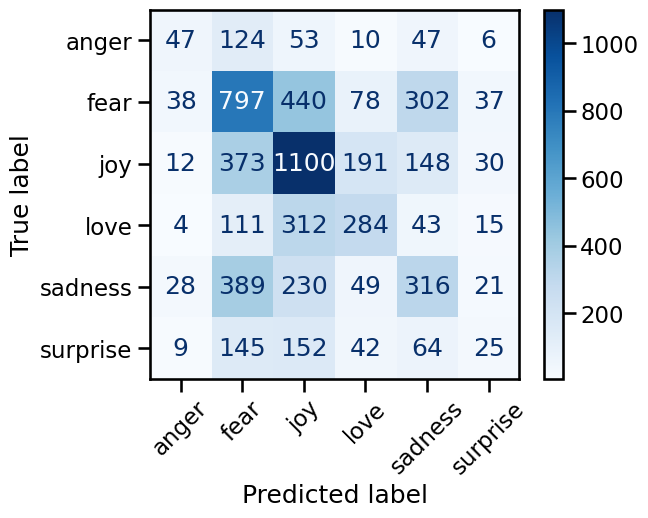

In [26]:
cm = confusion_matrix(y_test, pred_twitter_6, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.show()

Error Analysis

To better understand model limitations, we examined misclassified Reddit examples from the six-class evaluation. Several consistent patterns emerged:

1. Semantic overlap between emotions

Joy and love were frequently confused, particularly in comments expressing gratitude (e.g., “Thank you so much, this means a lot!”). While labeled as love, the model often predicted joy, suggesting difficulty distinguishing relational affection from general positivity.

2. Implicit fear or sarcasm

Comments labeled as fear were often misclassified as anger or sadness. Many fear-related examples relied on subtle contextual cues rather than explicit fear words (e.g., “This makes me really uneasy.”), which may not have strong lexical signals.

3. Short or ambiguous comments

Very short comments (e.g., “Wow.” or “Okay…”) were frequently misclassified due to limited contextual information. Transformer models improved slightly over the baseline in these cases but still struggled with ambiguity.

These errors highlight that emotion classification remains sensitive to subtle semantic distinctions and platform-specific linguistic norms, particularly under domain shift.

# Use of Generative AI Tools

Generative AI tools (ChatGPT) were used to:

- Generate preprocessing and tokenization code
- Assist with Hugging Face fine-tuning implementation
- Debug label alignment issues
- Suggest evaluation metrics and comparison strategies
- Improve visualization formatting

Limitations observed:
- Some Hugging Face dataset formatting errors required manual correction
- Label alignment required human validation
- AI-generated code required debugging for compatibility

Human expertise was essential for:
- Designing fair cross-domain evaluation
- Interpreting domain shift performance collapse
- Validating emotion category mappings

# Results and Limitations

### Key Findings

- The baseline TF-IDF + SVM model performs moderately well in-domain.
- Performance drops significantly on Reddit data, demonstrating domain shift.
- Transformer models typically improve in-domain performance.
- Cross-platform generalization remains challenging even with transformers.

### Limitations

- Class imbalance in Twitter dataset.
- Emotion label mapping reduces nuance.
- Reddit language differs structurally from Twitter.
- Multi-label emotions were simplified to single-label classification.
- Limited training epochs due to Colab constraints.

### Future Work

- Increase training epochs.
- Explore RoBERTa or DeBERTa.
- Use domain adaptation techniques.
- Experiment with multi-label classification.

# Conclusion

This study demonstrates that emotion classification models trained on Twitter data experience substantial performance degradation when evaluated on Reddit comments, even after aligning label spaces. While the fine-tuned DistilBERT model improved in-domain macro F1 compared to the TF-IDF + SVM baseline (0.39 vs. 0.33), cross-domain performance gains were modest (0.26 vs. 0.25 macro F1). These findings indicate that pretrained transformer architectures enhance in-domain performance but do not fully mitigate domain shift effects.

Our results reinforce the importance of dataset similarity, label alignment, and domain adaptation in NLP systems deployed across platforms. Future work should explore multi-label classification, domain-adaptive pretraining, and more robust transformer architectures such as RoBERTa or DeBERTa. Overall, this project highlights both the strengths and limitations of modern NLP pipelines when applied to real-world cross-platform emotion detection.